Formation OpenClassrooms DS-IML - **Marc Lefèvre**, <marc.lefevre@noos.fr>

# **Projet 8 : Petfinder.my Pawpularity Contest**

## **Exploration des données**

Ce notebook vous propose une rapide exploration des données du concours, ainsi qu'une explication de certains choix qui en ont découlé.

**Importations python**

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import imgaug.augmenters as iaa
import shutil

from time import time
from glob import glob
from PIL import Image

**Définition de constantes**

In [ ]:
INPUT = "/kaggle/input/petfinder-pawpularity-score/"
TRAIN = "/kaggle/input/petfinder-pawpularity-score/train"
TEST = "/kaggle/input/petfinder-pawpularity-score/test"
OUT = "/kaggle/working/"

**Fonction d'analyse des données**<br>Grâce à elle, nous construisons un dataframe regroupant les informations susceptibles de nous intéresser sur le dataset du concours.

In [5]:
def analyse_data(name, input_dir=INPUT, pics_dir=TRAIN):

    start = time()

    df_data = pd.read_csv(input_dir + name)
    train_pics = glob(pics_dir + "/*")

    dico = {}

    for file in train_pics:

        with Image.open(file) as img:

            id = file.split("/")[-1].split(".")[0]
            image_name = file.split("/")[-1]
            dico[id] = (file, image_name, img.size,
                        img.size[0], img.size[1], img.mode)

    df = pd.DataFrame.from_dict(dico, orient='index',
                                columns=["chemin", "nom", "taille",
                                         "longueur", "hauteur", "mode"])

    df = df.rename_axis('Id').reset_index()

    df = df.merge(df_data, left_on="Id", right_on="Id")

    return df

**Analyse**

In [6]:
df = analyse_data("train.csv")
df.head(1)

,Id,chemin,nom,taille,longueur,hauteur,mode,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,7954ebb5c90d9618e34959df0ad5f062,/kaggle/input/petfinder-pawpularity-score/trai...,7954ebb5c90d9618e34959df0ad5f062.jpg,"(720, 960)",720,960,RGB,0,1,1,1,0,0,0,0,0,0,0,0,38


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9912 entries, 0 to 9911
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   chemin         9912 non-null   object
 2   nom            9912 non-null   object
 3   taille         9912 non-null   object
 4   longueur       9912 non-null   int64 
 5   hauteur        9912 non-null   int64 
 6   mode           9912 non-null   object
 7   Subject Focus  9912 non-null   int64 
 8   Eyes           9912 non-null   int64 
 9   Face           9912 non-null   int64 
 10  Near           9912 non-null   int64 
 11  Action         9912 non-null   int64 
 12  Accessory      9912 non-null   int64 
 13  Group          9912 non-null   int64 
 14  Collage        9912 non-null   int64 
 15  Human          9912 non-null   int64 
 16  Occlusion      9912 non-null   int64 
 17  Info           9912 non-null   int64 
 18  Blur           9912 non-null

Nous voyons ici qu'il n'y a pas de données manquantes.

In [8]:
df.describe()

,longueur,hauteur,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,804.426251,904.284302,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,270.211921,156.905980,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,90.000000,113.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,675.000000,908.750000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,720.000000,960.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,960.000000,960.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1280.000000,1280.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


Il ne semble pas non plus y avoir de données erronées.<br><br>En observant les variables "longueur" et "hauteur" on peut voir que la taille des photos varie beaucoup. Plus particulièrement que certaines photos sont très "petites", ce qui pourrait nuire à leur "pawpularity". De même, certaines photos sont peut-être très "allongées" du fait d'avoir été prise avec un smartphone, ce qui peut également diminuer leur impact.<br><br>Nous décidons donc de procéder à un peu de **feature engineering**, à savoir que nous ajouterons deux nouvelles **features** à nos métadata, une variable rendant compte du ratio des images, et une autre de leur taille.

In [9]:
df.describe(include = "object")

,Id,chemin,nom,taille,mode
count,9912,9912,9912,9912,9912
unique,9912,9912,9912,1808,1
top,7954ebb5c90d9618e34959df0ad5f062,/kaggle/input/petfinder-pawpularity-score/trai...,7954ebb5c90d9618e34959df0ad5f062.jpg,"(720, 960)",RGB
freq,1,1,1,3527,9912


Toutes les photos sont en mode **RGB**

**Pawpularity Score**<br><br>Observons sa distribution par tranche de dix.

In [10]:
def paw_class_10(x):

        if x > 89:
            return "9"
        
        elif x > 79:
            return "8"
        
        elif x > 69:
            return "7"

        elif x > 59:
            return "6"
        
        elif x > 49:
            return "5"

        elif x > 39:
            return "4"
        
        elif x > 29:
            return "3"

        elif x > 19:
            return "2"
        
        elif x > 9:
            return "1"
        
        else:
            return "0"
        
df["dizaine"] = df["Pawpularity"].map(paw_class_10)

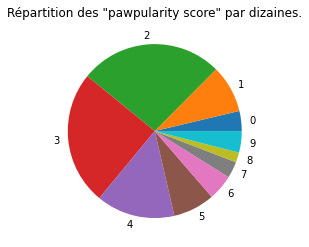

In [11]:
numbers = df["dizaine"].value_counts()
labels = df["dizaine"].value_counts().index

dico = {}

for num, lab in zip(numbers, labels):

    dico[lab] = num

plt.pie([dico[k] for k in sorted(labels)], labels=sorted(labels))
plt.title('Répartition des "pawpularity score" par dizaines.')
plt.show()

La répartition des fourchettes de score est loin d'être équilibrée. Nous rajouterons donc une variable **dizaine** aux métadata qui classera les individus par tranche de score. Nous nous en servirons pour créer des échantillons **train** et **test** par tranche. Et éventuellement pour calculer des poids dont on pourrait se servir lors des modélisations.

**FIN de la partie exploration**